# Mosaik building blocks
Last edited: July 31 2018 <br>
Contributors: Karen Pardos Olsen, Daniel Esteban Morales Bondy <br>
Made with: python v3.6.5, pandas v0.23.4, see the requierements.txt file for further requirements. <br>
Purpose: A demonstration of how mosaik works, with a slow build up from a simple one-energy-supply scenario to a multi-energy one.

Import mosaik package as well as some modules for plotting. <br>
The strings "data_path" and "plot_path" are used to store temporary files and plots in subfolders.

In [3]:
%matplotlib notebook
import mosaik
import mosaik.util
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
data_path = 'temp_files/'
plot_path = 'plots/'

Let's look at a house that is supplied with power from the grid and nothing else. <br>
No solar PVs, batteries or other smart devices. <br>
Here's a sketch of that 2-component circuit:

<img src="graphics/grid_demand.png" width="400">

We will pretend that we have measured the demand for this house over a 24hr timespan and that the house has been supplied with power from the grid the whole time. 
As such, mosaik doesn't have to calculate anything, and the demand will be reflected as negative power provided to the grid as we will see in the final plot.

Now follows **5 steps** to create and run a simulation of this system. 

Following that, we will add items (called entities in mosaik) to the system.

### 1. Define entities
First, we need to tell mosaik what kind of components live inside the system we want to simulate. 
In mosaik, these components are called **entities** and the system is called **world**. 
We create the entities by building a function that defines them and can add them to the world. 
We call this function "init_entities" because it initializes the entities that will live in the world. 
Note that the entities are not connected to each other yet, that comes in step 4. 

In order to create the entities, we have the following information: 
- "Demand" is just a timeseries of demand to be read from a file ('signals.h5' in mosaik_demand.py)
- "Grid" just balances power consumption with supply (mosaik_grid.py)
- "Collector" makes a log of the data of interest and stores it in HDF5 binary data format.

You will notice, that the function below takes "world" as an argument and calls "world.start()". 
This function takes whatever arguments we pass for each entity and stores them in **world**. 
In more correct terms, start() adds the entities as attributes to the object **world** which is itself an instance of the class mosaik.World(). 
If you're just too curious, you can check out the raw code for world.start() in scenario.py in the mosaik module.

We also give "filename" as an argument, to tell the "Collector" where to store the output of the simulation.

Finally, init_entities() also returns two dictionaries, "sim_dict" and "entity_dict", which can be used to connect the entities later (see step 4).

By reading the comments inside init_entities() you can get an idea of where this information is given to mosaik.

In [4]:
filename_1 = 'grid_demand_output'
def init_entities(world,filename = data_path+filename_1):
    sim_dict = {}
    entity_dict = {}
    
    ## Demand
    # Params:
    #   rated_capacity: Maximal power draw (indicative) [kW]
    # Output:
    #   P: Current power draw [kW]
    # Desc:
    #   Read demand time series from a CSV file (=> Prel in [0, 1])
    #   P = Pmax * Prel

    demand_sim = world.start(
            'DemandModel',
            eid_prefix='demand_',
            step_size=1)
    demand_entity_1 = demand_sim.DemandModel(rated_capacity=4, seriesname='/flexhouse_20180218')
    sim_dict['demand'] = demand_sim
    entity_dict['demand1'] = demand_entity_1
    
    ## Grid model
    # Params:
    #   droop: Relationship between power draw and voltage change [V/kW] (usually <0)
    #   V0: Base voltage [V]
    # Output:
    #   V: Current voltage at bus [V]
    #   Pgrid: Current power draw from the grid [kW]
    # Input:
    #   P: Current power draw from units (Many connections) [kW]
    # Desc:
    #   Pgrid = - (P_1 + ... + P_N)
    #   V = V0 + droop * Pgrid

    grid_sim = world.start(
            'SimpleGridModel',
            eid_prefix='grid_',
            step_size=1)
    grid_entity_1 = grid_sim.SimpleGridModel(V0=240, droop=0.1)
    sim_dict['grid'] = grid_sim
    entity_dict['grid1'] = grid_entity_1
    
    ## Collector
    # Params:
    #   Storefilename: String indicating the storage file to use
    # Input:
    #   GENERIC: Anything can be connected and will be logged
    # Desc:
    #   During simulation, save system state
    #   After simulation, write collected data to disk into the 'datastore' file with the given name.

    collector_sim = world.start(
            'CollectorSim',
            step_size=60,
            save_h5=True,
            h5_storename=filename,
            h5_framename='Monitor_SimpleCase_Centralized',
            print_results=False)
    collector_entity = collector_sim.Collector()
    sim_dict['collector'] = collector_sim
    entity_dict['collector'] = collector_entity
    
    return sim_dict, entity_dict

### 2. List entities in simulation configuration
Insert these three entities in the SIM_CONFIG dictionary which defines which simulators we can run:

In [5]:
SIM_CONFIG = {
    'DemandModel': {
        'python': 'mosaik_demand:DemandModel',
    },
    'SimpleGridModel': {
        'python': 'mosaik_grid:SimpleGridModel',
    },
    'CollectorSim': {
        'python': 'collector:Collector',
    },
}

### 3. Initiate "world"
Initiate the **world** object with the configuration given above and use the init_entities() function to insert entities into it:

In [6]:
world = mosaik.World(SIM_CONFIG)
sim_dict, entity_dict = init_entities(world)

Starting "DemandModel" as "DemandModel-0" ...
Starting "SimpleGridModel" as "SimpleGridModel-0" ...
Starting "CollectorSim" as "CollectorSim-0" ...


### 4. Connect components
We need to connect the house (demand1) to the grid (grid1), and both the grid and demand to the collector that will collect data points of power every second.

In [7]:
# Connect units to grid busbar
world.connect(entity_dict['demand1'], entity_dict['grid1'], ('P', 'P'))

# Connect to Collector
world.connect(entity_dict['demand1'], entity_dict['collector'], ('P', 'DemP'))
world.connect(entity_dict['grid1'], entity_dict['collector'], ('Pgrid', 'GridP'))

### 5. Run simulation!
Set end time and run simulation:

In [7]:
END = 24*60*60-1 # 24 hours, 1 MosaikTime = 1 second
world.run(END)

Starting simulation.
Simulation finished successfully.
      DemandModel-0.demand__0 SimpleGridModel-0.grid__0
                         DemP                     GridP
0                   -1.902000                  1.902000
60                  -1.900000                  1.900000
120                 -1.098000                  1.098000
180                 -1.099333                  1.099333
240                 -2.486667                  2.486667
300                 -2.470667                  2.470667
360                 -3.319333                  3.319333
420                 -3.825333                  3.825333
480                 -3.801333                  3.801333
540                 -3.110667                  3.110667
600                 -3.099333                  3.099333
660                 -1.774000                  1.774000
720                 -2.282667                  2.282667
780                 -1.780000                  1.780000
840                 -1.772667                  1.

### Plot the result
The Collector class saves the data in the DataFrame format so we can retrieve the results in the future, without having to execute the simulation again. In the snippet below we load the data into a variable called 'df':

In [8]:
store = pd.HDFStore(data_path+filename_1)
df = store[store.keys()[0]]
store.close()

Convert the time from seconds to hours:

In [9]:
df['time'] = df.index.values/60/60.

<IPython.core.display.Javascript object>


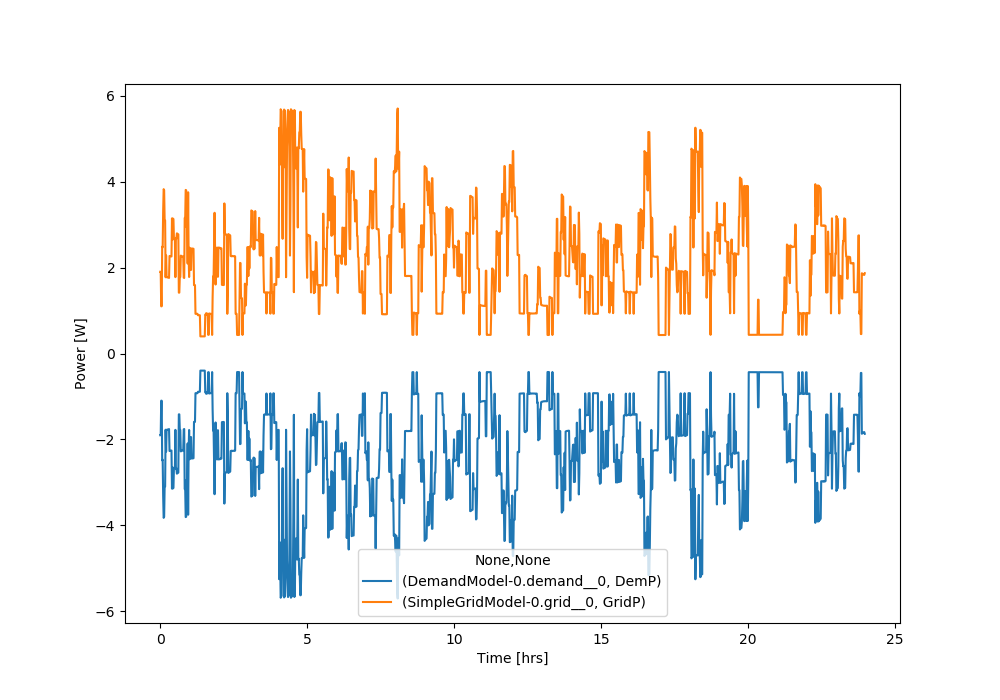

In [10]:
mpl.rcParams['font.size']=10
ax1 = df.plot(x='time',figsize=(10,7))
ax1.set_xlabel('Time [hrs]')
ax1.set_ylabel('Power [W]')
plt.savefig(plot_path+filename_1)

The power consumed by the house (shown as negative power production in blue), is exactly balanced by the positive power supplied by the grid (in orange).

## Adding a PV installation (or two)

Now let's add a couple of solar panels (PVs) to the house, converting the consumer into a prosumer. <br>
Here's a sketch of that 4-component circuit:

<img src="graphics/grid_demand_PV.png" width="500">

Again, we go through the same 5 steps, creating a new and slightly more complex world.

### 1. Define entities
We will create a new world, but build upon work done above by adding entities to the group of entities already initiated. For the PVs we will use a file of solar radiation data combined with a rated capacity of each PV (maximum output in kW, set here to be different for the two to tell them apart on plots). As you can see, both PVs are instances (entities) of the same PV simulator.

In [12]:
def add_entities_1(world,sim_dict,entity_dict):
    
    ## Photovoltaic Producer
    # Params:
    #   rated_capacity: Rated (maximal) power [kW]
    #   seriesname: Name of series in the data store
    # Output:
    #   P: Current production [kW]
    #   Pav: Current maximally available production [kW]
    #   Pmax: Current power limit [kW]
    # Input:
    #   Plimit: Current power limit [kW]
    # Desc:
    #   Read PV production from a CSV file (=> Pav)
    #   P = min(Pav, Plimit)

    pv_sim = world.start(
            'PVModel',
            eid_prefix='pv_',
            step_size=1)
    sim_dict['pv1'] = pv_sim
    
    pv_entity_1 = pv_sim.PVModel(
            rated_capacity=7,
            series_name='/PV715_20180510')
    entity_dict['pv1'] = pv_entity_1

    pv_entity_2 = pv_sim.PVModel(
            rated_capacity=3,
            series_name='/PV715_20180510')
    entity_dict['pv2'] = pv_entity_2
    
    return sim_dict, entity_dict

### 2. List entities in simulation configuration
This new simulator has to be listed in the SIM_CONFIG dictionary, so we add it to the previously defined dictionary:

In [13]:
SIM_CONFIG['PVModel']={'python':'mosaik_pv:PVModel'}

### 3. Initiate "world"
Now we initiate a new world (world_2) the same way as before, but adding the extra simulator and entities corresponding to the PVs and making sure to save the output from the collector in a different file (datastore_grid_demand_PV):

In [14]:
world_2 = mosaik.World(SIM_CONFIG)
filename_2 = 'grid_demand_PV_output'
sim_dict, entity_dict = init_entities(world_2,filename=data_path+filename_2)
sim_dict, entity_dict = add_entities_1(world_2,sim_dict,entity_dict)

Starting "DemandModel" as "DemandModel-0" ...
Starting "SimpleGridModel" as "SimpleGridModel-0" ...
Starting "CollectorSim" as "CollectorSim-0" ...
Starting "PVModel" as "PVModel-0" ...


### 4. Connect components
The PVs are connected to the grid (grid1) and solar power data is collected by the collector:

In [15]:
# Connect units to grid busbar
world_2.connect(entity_dict['demand1'], entity_dict['grid1'], ('P', 'P'))
world_2.connect(entity_dict['pv1'], entity_dict['grid1'], ('P', 'P'))
world_2.connect(entity_dict['pv2'], entity_dict['grid1'], ('P', 'P'))

# Connect to Collector
world_2.connect(entity_dict['demand1'], entity_dict['collector'], ('P', 'DemP'))
world_2.connect(entity_dict['grid1'], entity_dict['collector'], ('Pgrid', 'GridP'))
world_2.connect(entity_dict['pv1'], entity_dict['collector'], ('P', 'SolarP'))
world_2.connect(entity_dict['pv2'], entity_dict['collector'], ('P', 'SolarP'))

### 5. Run simulation!
Set end time and run simulation:

In [16]:
END = 24*60*60-1 # 24 hours, 1 MosaikTime = 1 second
world_2.run(END)

Starting simulation.
Simulation finished successfully.
      DemandModel-0.demand__0 SimpleGridModel-0.grid__0 PVModel-0.pv__0  \
                         DemP                     GridP          SolarP   
0                   -1.902000                  1.902000             0.0   
60                  -1.900000                  1.900000             0.0   
120                 -1.098000                  1.098000             0.0   
180                 -1.099333                  1.099333             0.0   
240                 -2.486667                  2.486667             0.0   
300                 -2.470667                  2.470667             0.0   
360                 -3.319333                  3.319333             0.0   
420                 -3.825333                  3.825333             0.0   
480                 -3.801333                  3.801333             0.0   
540                 -3.110667                  3.110667             0.0   
600                 -3.099333                

### Plot the result

In [17]:
store = pd.HDFStore(data_path+filename_2)
df = store[store.keys()[0]]
store.close()
df['time'] = df.index.values/60/60.

<IPython.core.display.Javascript object>


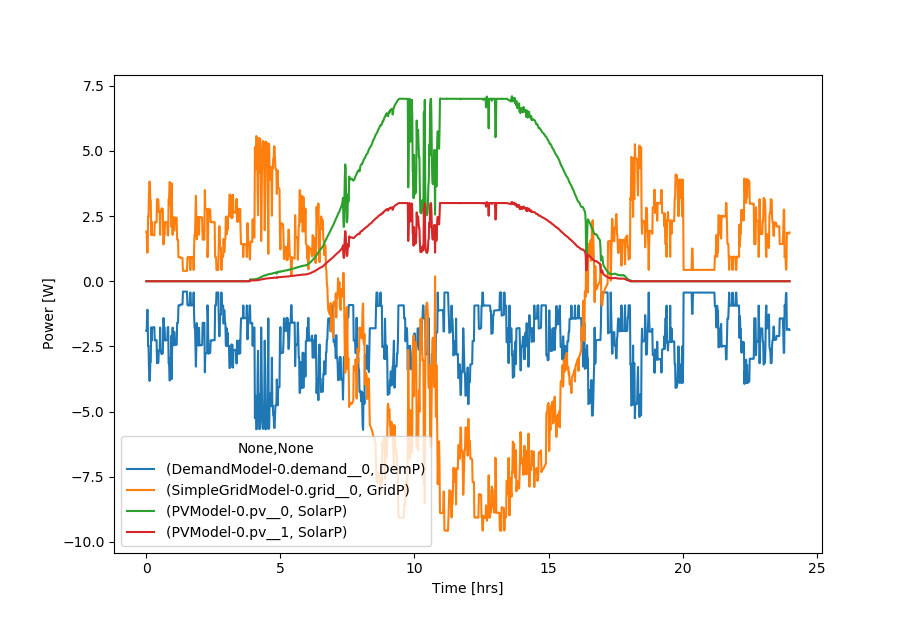

In [18]:
mpl.rcParams['font.size']=10
ax1 = df.plot(x='time',figsize=(5,3))
ax1.set_xlabel('Time [hrs]')
ax1.set_ylabel('Power [W]')
plt.savefig(plot_path+filename_2)

In the beginning of the day, power consumed by the house (shown as negative power production in blue), is again balanced by the positive power supplied by the grid (in orange).

But during the hours of the day with sunlight (8 AM - 4 PM roughly), the PVs are producing more power than what is consumed by the house, and it has to dump the surplus of energy onto the grid. Therefore, the power supplied by the grid goes from mirroring the demand, to becoming negative at times when the PVs are producing the most power.

## Adding a battery (and some controllers)
In Denmark, any surplus in energy production from PVs (as in the example above) can be returned to the grid, but with no monetary gain for the prosumer. That is, Ørsted (for example) will not pay you for the extra electricity that you send back to the grid. Thus, it becomes advantageous for the prosumer to store this surplus in energy for later, say, when the sun has gone down.

That's a common Home Energy Management System scenario, which can be sketched like this:
<img src="graphics/grid_demand_PV_batt.png" width="800">

Again, we go through the same 5 steps.

### 1. Define entities
Again, we will create a new world (world #3) , by adding entities to the group of entities in the previous example. For the battery, we will use the battery model which can be found in my_batt_sim.py. Given the "charge change rate", this model can update the current State of Charge and draws a new limit on what power can be charged/discharged at any time step.

There's an extra complication here, since we only wish to charge the battery when there is a surplus of power generated from the PVs. In order to for the system to make this decision automatically, we add a controller (control_entity_1) as a separate entity. The controller checks in any time step whether there is a power export to the grid, and if so, connect the battery so that it may charge. When needed, the controller can start discharging the battery instead of using power from the grid.

In [19]:
def add_entities_2(world,sim_dict,entity_dict):
    
    ## Battery
    # Params:
    #   rated_charge_capacity: Maximum charge power (>0) [kW]
    #   rated_discharge_capacity: Maximum discharge power (>0) [kW]
    #   rated_capacity: Maximal state of charge (>0) [kWs]
    #   initial_charge_rel: Battery fill % at start (in [0,1]) [r.u.]
    #   charge_change_rate: Time-delay factor (in [0,1], 1 => instant response)
    #   dt: Conversion factor for one time step (default: 1.0/(60*60) = 1sec/time step)
    # Output:
    #   P: Current production/consumption [kW]
    #   SoC: Current state-of-charge (in [0, SoCmax]) [kWs]
    # Input:
    #   Pset: Current power target [kW]
    # Desc:
    #   P>0 => the battery is outputting power into the grid (discharging)
    #   Pset = Pset bounded to [-Pmax, Pmax]
    #   P(t) = kappa*Pset + (1-kappa)*P(t-1) bounded to [-SoC, SoCmax-SoC]
    #   SoC(t) = SoC(t-1) + P(t) bounded to [0, SoCmax]

    batt_sim = world.start(
            'BatteryModel',
            eid_prefix='batt_',
            step_size=1)
    batt_entity_1 = batt_sim.BatteryModel(
            rated_capacity=10,
            rated_discharge_capacity=30,
            rated_charge_capacity=30,
            initial_charge_rel=0.5,
            charge_change_rate=0.03,
            )
    sim_dict['batt'] = batt_sim
    entity_dict['batt1'] = batt_entity_1
    
    ## Controller
    # Params:
    #   kappa: Time-delay compensation factor (usually in [0, 1], 1 => instant response) [a.u.]
    # Input:
    #   Pgrid: Current power draw [kW]
    #   SoC: Battery state-of-charge [kWs]
    # Output:
    #   Pset: Battery power setpoint [kW]
    # Desc:
    #   Psett(t) = kappa * Pgrid + (1 - kappa) * Psett(t-1)
    
    control_sim = world.start(
            'ControlModel',
            eid_prefix='demand_',
            step_size=1)
    control_entity_1 = control_sim.ControlModel(setpoint_change_rate=0.50)
    
    sim_dict['control'] = control_sim
    entity_dict['control1'] = control_entity_1
    
    return sim_dict, entity_dict

### 2. List entities in simulation configuration
The new entities have to be listed in the SIM_CONFIG dictionary:

In [20]:
SIM_CONFIG['BatteryModel'] = {'python': 'mosaik_battery:BatteryModel'}
SIM_CONFIG['ControlModel'] = {'python': 'mosaik_control:ControlModel'}

### 3. Initiate "world"
Now we initiate a new world (world_3) the same way as before, but adding the extra entity corresponding to a battery and making sure to save the output from the collector in a different file (datastore_grid_demand_PV_batt):

In [12]:
world_3 = mosaik.World(SIM_CONFIG)
filename_3 = 'grid_demand_PV_batt_output'
sim_dict, entity_dict = init_entities(world_3,filename=data_path+filename_3)
sim_dict, entity_dict = add_entities_1(world_3,sim_dict,entity_dict)
sim_dict, entity_dict = add_entities_2(world_3,sim_dict,entity_dict)

OSError: [Errno 98] Address already in use

### 4. Connect components
The controller is connected to the grid and to the battery. The keyword argument "time_shifted" is added in order to have a loop in the network, something that is otherwise not allowed in mosaik.

In [22]:
# Connect units to grid busbar
world_3.connect(entity_dict['demand1'], entity_dict['grid1'], ('P', 'P'))
world_3.connect(entity_dict['pv1'], entity_dict['grid1'], ('P', 'P'))
world_3.connect(entity_dict['batt1'], entity_dict['grid1'], ('P', 'P'))
world_3.connect(entity_dict['pv2'], entity_dict['grid1'], ('P', 'P'))

# Connect to Collector
world_3.connect(entity_dict['demand1'], entity_dict['collector'], ('P', 'DemP'))
world_3.connect(entity_dict['grid1'], entity_dict['collector'], ('Pgrid', 'GridP'))
world_3.connect(entity_dict['pv1'], entity_dict['collector'], ('P', 'SolarP'))
world_3.connect(entity_dict['pv2'], entity_dict['collector'], ('P', 'SolarP'))
world_3.connect(entity_dict['batt1'], entity_dict['collector'], ('P', 'BattP'))
world_3.connect(entity_dict['batt1'], entity_dict['collector'], ('SoC', 'BattSoC'))

# Connect controller
world_3.connect(entity_dict['grid1'], entity_dict['control1'], ('Pgrid', 'Pgrid'))
world_3.connect(entity_dict['control1'], entity_dict['batt1'], ('Pset', 'Pset'), time_shifted=True, initial_data={'Pset': 0.0})
world_3.connect(entity_dict['batt1'], entity_dict['control1'], ('relSoC', 'relSoC'))

### 5. Run simulation!
Set end time and run simulation:

In [23]:
END = 24*60*60-1 # 24 hours, 1 MosaikTime = 1 second
world_3.run(END)

Starting simulation.
Progress: 1.36%Simulation finished successfully.
      BatteryModel-0.batt__0           DemandModel-0.demand__0  \
                       BattP   BattSoC                    DemP   
0               0.000000e+00  5.000000               -1.902000   
60              1.488098e+00  4.970220               -1.900000   
120             1.137929e+00  4.946798               -1.098000   
180             1.356674e+00  4.927202               -1.099333   
240             1.959305e+00  4.907639               -2.486667   
300             2.718720e+00  4.865007               -2.470667   
360             4.065624e+00  4.816774               -3.319333   
420             3.967243e+00  4.760102               -3.825333   
480             3.879206e+00  4.696119               -3.801333   
540             3.282880e+00  4.633529               -3.110667   
600             2.927424e+00  4.582616               -3.099333   
660             2.242735e+00  4.550598               -1.774000   
720   

### Plot the result

<IPython.core.display.Javascript object>


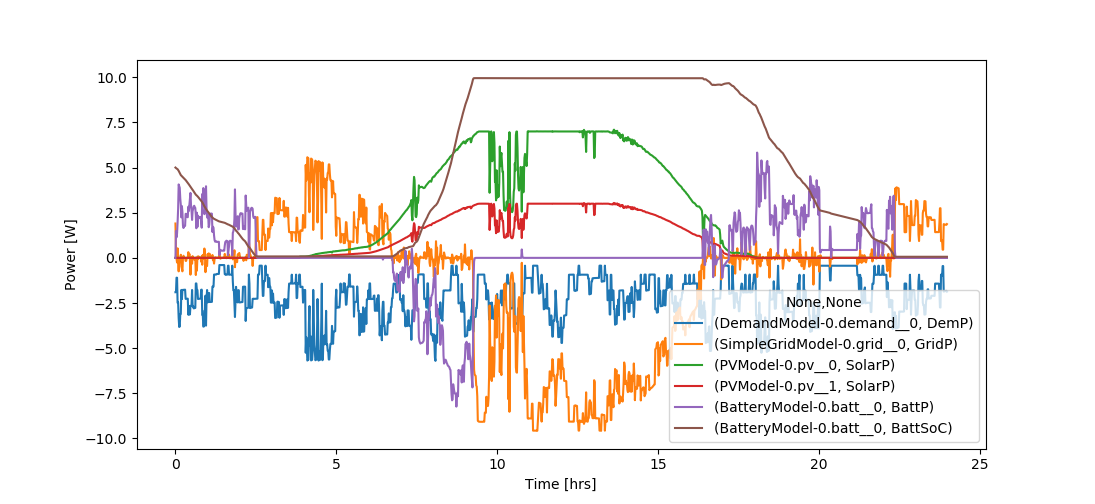

In [15]:
store = pd.HDFStore(data_path+filename_3)
df = store[store.keys()[0]]
store.close()
df['time'] = df.index.values/60/60.
mpl.rcParams['font.size']=10
ax1 = df.plot(x='time',figsize=(5,3))
ax1.set_xlabel('Time [hrs]')
ax1.set_ylabel('Power [W]')
plt.savefig(plot_path+filename_3)

Now, we are storing some of the power from the PVs in the battery instead of sending it back to the grid. After around 10 AM, the battery is saturated and the extra energy from the PVs cannot be stored anywhere. However, on a more Danish (i.e. cloudy) day, this would not be such a big problem.